# 言語モデルとRNN

## 言語モデル

embeddingを直接推定するのではなく、単語予測モデル（言語モデル）を構築して副次的にembeddingを取得することになる。

言語モデルとは、尤もらしい文章を生成できるような確率分布を習得するために、文章の確率を推定するモデルのこと。

ある文章$S$をトークン化したのを$(w_1, w_2, \cdots, w_n)$と表記するならば、

$$
P(S)=P(w_1, w_2, \cdots, w_n)
$$

を求めたいということになる。これは条件付き確率の積として表せる

$$
\begin{align}
P(w_1, w_2, \cdots, w_n)
&= P(w_1) \times P(w_2|w_1) \times P(w_3|w_1, w_2) \times \cdots\\
&= \prod_{i=1}^n p(w_i|\boldsymbol{c}_i)
\end{align}
$$

ここで$\boldsymbol{c}_i$は$w_i$より前のトークン列$\boldsymbol{c}_i=(w_1,w_2,\cdots,w_{i-1})$で、**文脈**（context）と呼ばれる



:::{note} 同時確率の分解

これは確率の乗法定理

$$
P(A,B) = P(A|B) P(B)
$$

に基づく。


$w_m$までの単語を$C_m$とすると、

$$
P(\underbrace{w_1, \dots, w_{m-1}}_{C_m}, w_m)
= P(C_m, w_m)
= P(w_m | C_m) P(C_m)
$$

さらに

$$
P(C_m) = 
P(\underbrace{w_1, \dots, w_{m-2}}_{C_{m-1}}, w_{m-1})
= P(C_{m-1}, w_{m-1})
= P(w_{m-1} | C_{m-1}) P(C_{m-1})
$$

となる。これを繰り返すことで上記のようになる
:::

### 例

言語モデルは文脈をもとに次の単語を予測する。例えば

> Alice is reading a book in the room. Bob comes into the room and says hi to `?`

の?に入る語を予測する

### 語順の問題

Word2Vecに使われたcontinuous bag-of words (CBOW) のようなFeed-Forward Networkによる言語モデルでは、コンテキストの語順が考慮されない

## RNN型ニューラル言語モデル（Mikolov + 2010）

Mikolov et al. (2010). [Recurrent neural network based language model](https://wtf-deeplearning.github.io/machine-translation/rnnlm_mikolov.pdf).

## RNN

RNNは前のトークンまでの情報を次のトークンの出力に渡すパスが存在する。
トークンの系列を時系列モデルになぞらえて時刻と表現すると、時刻$t$の出力$\boldsymbol{h}_t$は

$$
\newcommand{\b}[1]{\boldsymbol{#1}}
\b{h}_t = \text{tanh}(
  \b{W}_h
  \b{h}_{t-1}
  +
  \b{W}_x
  \b{x}_t
  +
  \b{b}
)
$$

となる。ここで$\boldsymbol{x}_t$は入力で、$\boldsymbol{h}_{t-1}$は1時刻前の出力、$\b{W}_h, \b{W}_x$は重みで$\b{b}$はバイアスである。

なお、出力$\b{h}$は**隠れ状態**（hidden state）と呼ばれる事が多い


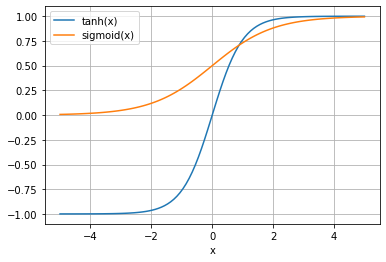

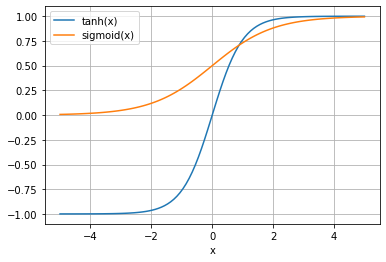

In [28]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

x = np.linspace(-5, 5, 100)
y_tanh = [tanh(a) for a in x]
y_sigmoid = [sigmoid(a) for a in x]

fig, ax = plt.subplots()
ax.plot(x, y_tanh, label="tanh(x)")
ax.plot(x, y_sigmoid, label="sigmoid(x)")
ax.legend()
ax.grid(True)
ax.set(xlabel="x")

from myst_nb import glue
glue("tanh_fig", fig)

:::{note} 双曲線正接（hyperbolic tangent: tanh）関数

RNNの場合、活性化関数にはtanh

$$
\text{tanh}(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}
$$

を用いることが多い。tanhはシグモイド関数と形状が似ているが、値域は$[-1, 1]$と負の値を許しており、また二次微分の減衰がゆっくりとゼロになるため勾配消失が起きにくいという特性がある。

```{glue:figure} tanh_fig
:figwidth: 80%

tanh
```
:::

### Truncated BPTT

RNNの誤差逆伝播法は、時間方向への逆伝播法ということで**Backproagation Through Time（BPTT）**と呼ばれる。

しかし長い文章を扱う場合、すべてのトークンを使うと学習の際にメモリに乗り切らない問題や勾配が不安定になる問題がある。
そこで、逆伝播のときはトークン系列を分割して学習する（順伝播は全部つながるようにする）方法があり、これを**Truncated BPTT**という。




## 実装（PyTorch）


In [32]:
import torch
from torch import nn

rnn = nn.RNN(10, 20, 2)
input = torch.randn(5, 3, 10)
h0 = torch.randn(2, 3, 20)
output, hn = rnn(input, h0)
output

tensor([[[ 0.1399, -0.5726, -0.0140,  0.2796, -0.2825,  0.4702,  0.4212,
           0.7718, -0.2773,  0.2709, -0.5992,  0.7916,  0.8245, -0.4076,
           0.0654,  0.7407, -0.8359, -0.2478, -0.3579, -0.1336],
         [ 0.7899, -0.4600,  0.0361,  0.1125, -0.5406, -0.2414,  0.5075,
           0.8431,  0.3200,  0.2554, -0.9069,  0.8836,  0.6350, -0.6326,
          -0.3479,  0.8554,  0.7269, -0.8816, -0.9274, -0.4843],
         [ 0.8359, -0.8962, -0.1628,  0.4329, -0.0037,  0.6804, -0.4292,
          -0.0820,  0.5595, -0.9086, -0.2509, -0.1206, -0.3601, -0.2747,
           0.3013,  0.3774,  0.0441, -0.8133, -0.0974, -0.2685]],

        [[ 0.3256, -0.0518, -0.2270,  0.7091, -0.1449,  0.1094,  0.0823,
           0.4900,  0.0459, -0.3352, -0.3053,  0.7692,  0.3135,  0.1655,
          -0.0482, -0.1065,  0.6144, -0.4425, -0.5893, -0.1121],
         [ 0.1875, -0.0284,  0.0709,  0.7472,  0.5352,  0.0527, -0.2583,
           0.2674,  0.1671, -0.3812, -0.4540,  0.2505,  0.0990,  0.4348,
        

## 実装（Python）

参考：ゼロから作るDeep Learning 2

In [30]:
import numpy as np

class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx),
                      np.zeros_like(Wh),
                      np.zeros_like(b)]
        self.chache = None

    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = Wh @ h_prev + Wx @ x + b
        h_nrex = np.tanh(t)
        self.cache = (x, h_prev, h_next)
        return h_next

    def backword(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache
        dt = dh_next * (1 - h_next ** 2)
        db = np.sum(dt, axis=0)
        dWh = h_prev.T @ dt
        dh_prev = Wh @ dt
        dWx = x @ dt
        dx = Wx @ dt
        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db
        return dx, dh_prev
